## Import Libraries

In [29]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import random


# Load and Split Dataset

In [2]:
# Set device
device = torch.device("cuda")

In [3]:
# Load the multilabel data
data = pd.read_csv('LandUse_Multilabeled.txt', sep='\t')
X = data.iloc[:, 0]  # Image names
y = data.iloc[:, 1:]  # Labels

# Split into train, validation, and test sets
# No stratification is applied because it gave a message that some classes only occur once
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [8]:
num_labels = len(data.iloc[0, :])-1

In [9]:
print("Train size: ", len(X_train))
print("Validation size: ", len(X_val))
print("Test size: ", len(X_test))

Train size:  1470
Validation size:  315
Test size:  315


# Define Dataset Class

In [10]:
class UCMercedDataset(Dataset):
    def __init__(self, image_names, labels, image_dir, transform=None):
        self.image_names = image_names
        self.labels = labels
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        base_filename = self.image_names.iloc[idx]
        subfolder = base_filename[:-2]     # 'airplane22' -> 'airplane'

        img_path = os.path.join("Images", subfolder, f"{base_filename}.tif")

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found at: {img_path}")

        image = datasets.folder.default_loader(img_path)
        label = torch.tensor(self.labels.iloc[idx].values, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label


# Preprocess Images

In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = UCMercedDataset(X_train, y_train, 'Images', transform)
val_dataset = UCMercedDataset(X_val, y_val, 'Images', transform)
test_dataset = UCMercedDataset(X_test, y_test, 'Images', transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# Load and Adjust Pretrained Models

In [ ]:
# Load DINO v2 ResNet 50
resnet50 = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')

# Load DINO v2 ViT-S/8
vits8 = torch.hub.load('facebookresearch/dino:main', 'dino_vits8')

In [12]:
# Change the Dino model to multi-label classification
class DinoResNetMultiLabel(nn.Module):
    def __init__(self, base_model, num_labels):
        super().__init__()
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])  # remove final classification layer
        self.classifier = nn.Linear(2048, num_labels)  # 2048 is the output feature dim of ResNet50

    def forward(self, x):
        x = self.backbone(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [13]:
# Change the ViT model to multi-label classification
class DinoViTMultiLabel(nn.Module):
    def __init__(self, base_model, num_labels):
        super().__init__()
        self.backbone = base_model
        self.classifier = nn.Linear(base_model.embed_dim, num_labels)  # embed_dim is the output feature dim of ViT-S/8

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

## Prepare for training

In [16]:
# Model setup
resnet_model = DinoResNetMultiLabel(resnet50, num_labels).to(device)
vits_model = DinoViTMultiLabel(vits8, num_labels).to(device)

# Loss and optimizers
criterion = nn.BCEWithLogitsLoss()
resnet_optimizer = torch.optim.Adam(resnet_model.parameters(), lr=1e-4)
vits_optimizer = torch.optim.Adam(vits_model.parameters(), lr=1e-4)

# Define Training Loop

In [17]:
# Training function
def train_model(model, optimizer, name):
    for epoch in range(20):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"[{name}] Epoch {epoch+1}: Train Loss = {avg_loss:.4f}")

        validate_model(model, name)

# Validation function
def validate_model(model, name):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = torch.sigmoid(model(images))
            preds = (outputs > 0.5).int()

            all_preds.append(preds.cpu())
            all_targets.append(labels.cpu().int())

    preds = torch.cat(all_preds)
    targets = torch.cat(all_targets)

    f1 = f1_score(targets, preds, average="macro", zero_division=0)
    print(f"[{name}] Validation F1 score: {f1:.4f}\n")

# Train and Evaluate Models

In [ ]:
# Train ResNet 50
print("Training ResNet 50...")
train_model(resnet_model, resnet_optimizer, name="ResNet50")

In [ ]:
# Train ViT-S/8
print("Training ViT-S/8...")
train_model(vits_model, vits_optimizer, name="ViT-S/8")

In [ ]:
# Save the trained models
torch.save(resnet_model.state_dict(), "resnet50_trained.pth")
torch.save(vits_model.state_dict(), "vit_s8_trained.pth")

## Test the Models on the test set

In [18]:
# Load the trained models
resnet_model.load_state_dict(torch.load("resnet50_trained.pth"))
vits_model.load_state_dict(torch.load("vit_s8_trained.pth"))
resnet_model.eval()
vits_model.eval()

# Re insure that the models are on the GPU
resnet_model.to(device)
vits_model.to(device)

DinoViTMultiLabel(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): La

In [19]:
# Get the label names from the data
label_names = list(y.columns)

In [20]:
# get 5 random images from the test set to visualize
def get_random_samples(data_loader, num_samples=5):
    all_images = []
    all_labels = []
    for images, labels in data_loader:
        for i in range(len(images)):
            all_images.append(images[i])
            all_labels.append(labels[i])
    indices = random.sample(range(len(all_images)), num_samples)
    return [all_images[i] for i in indices], [all_labels[i] for i in indices]

In [27]:
# Test evaluation function
def test_model(model, name):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = torch.sigmoid(model(images))
            preds = (outputs > 0.5).int()

            all_preds.append(preds.cpu())
            all_targets.append(labels.cpu().int())

    preds = torch.cat(all_preds)
    targets = torch.cat(all_targets)

    f1 = f1_score(targets, preds, average="macro", zero_division=0)
    precision = precision_score(targets, preds, average="macro", zero_division=0)
    recall = recall_score(targets, preds, average="macro", zero_division=0)
    accuracy = accuracy_score(targets, preds)
    print(f"[{name}] Test F1 score: {f1:.4f}\n"
          f"Test Precision: {precision:.4f}\n"
          f"Test Recall: {recall:.4f}\n"
          f"Test Accuracy: {accuracy:.4f}\n")

In [30]:
# Test the models
test_model(resnet_model, "ResNet50")
test_model(vits_model, "ViT-S/8")

[ResNet50] Test F1 score: 0.9302
Test Precision: 0.9578
Test Recall: 0.9064
Test Accuracy: 0.5714

[ViT-S/8] Test F1 score: 0.9530
Test Precision: 0.9635
Test Recall: 0.9438
Test Accuracy: 0.6730



In [41]:
# Run inference and visualize results
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def unnormalize(img_tensor):
    return (img_tensor * std) + mean

def show_predictions(model, model_name):
    images, labels = get_random_samples(test_loader)

    fig, axs = plt.subplots(1, len(images), figsize=(20, 5))
    for i, (img, true_label) in enumerate(zip(images, labels)):
        img_input = img.unsqueeze(0).to(device)
        with torch.no_grad():
            output = torch.sigmoid(model(img_input))
            pred_label = (output > 0.5).int().squeeze().cpu()

        true_label = true_label.int()
        true_classes = [label_names[j] for j in range(len(true_label)) if true_label[j] == 1]
        pred_classes = [label_names[j] for j in range(len(pred_label)) if pred_label[j] == 1]

        axs[i].imshow(unnormalize(img).permute(1, 2, 0).cpu().clip(0, 1))
        axs[i].set_title(f"Actual:\n{', '.join(true_classes)}\n\nPredicted:\n{', '.join(pred_classes)}", fontsize=9)
        axs[i].axis("off")

    plt.suptitle(f"{model_name} Predictions", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

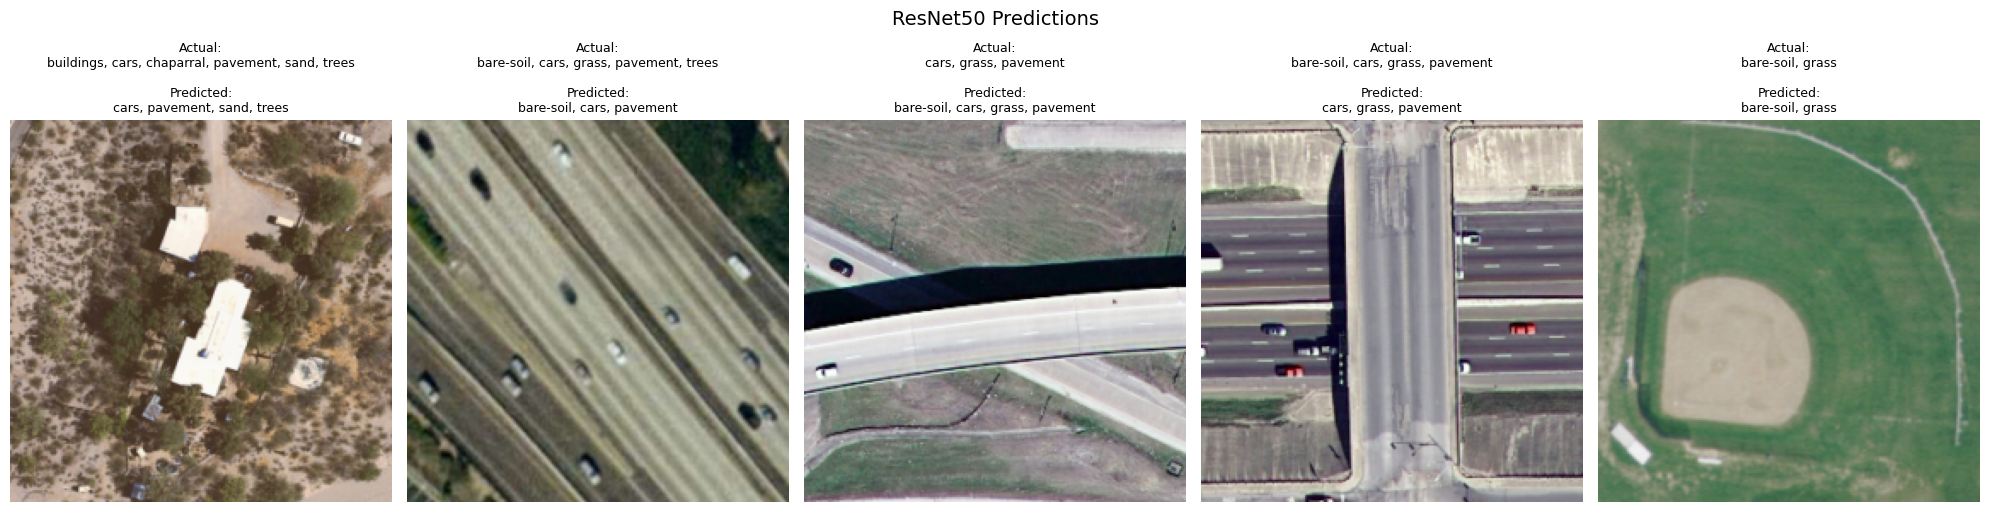

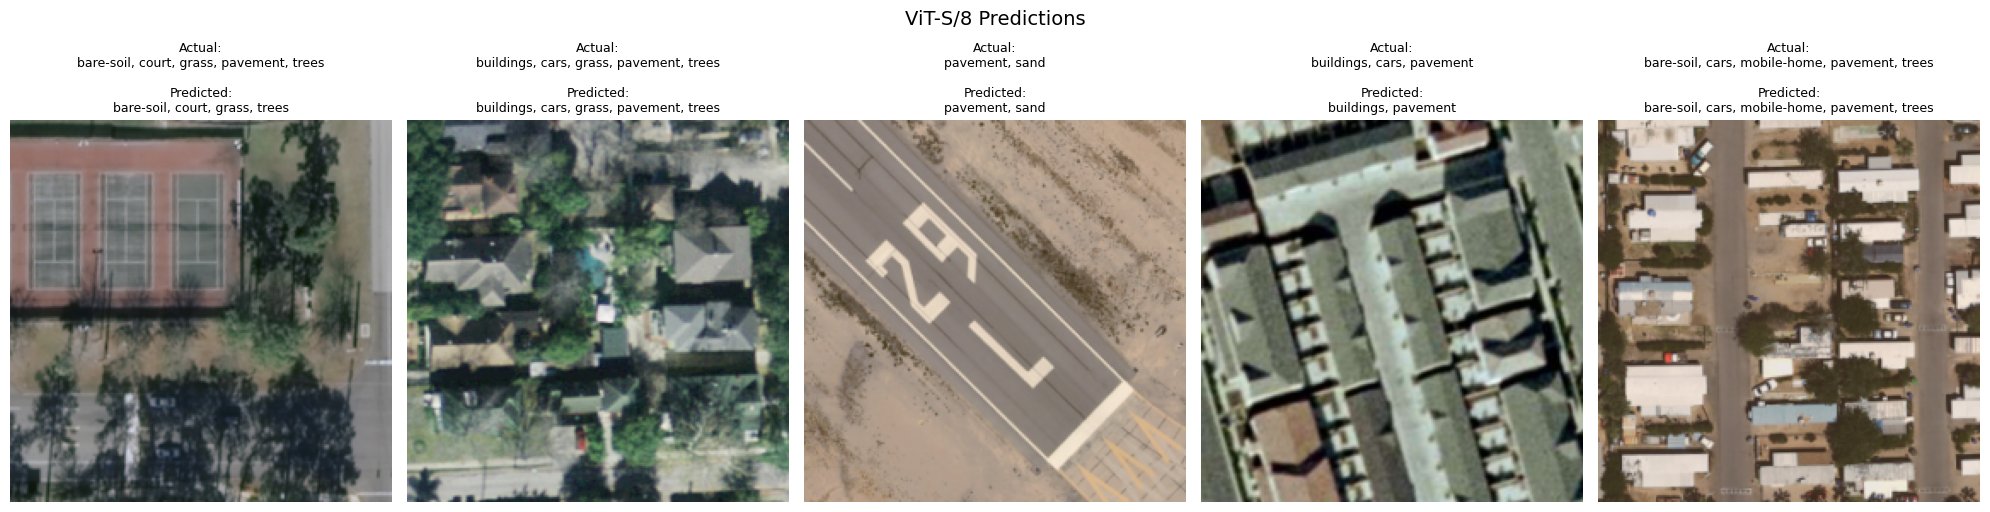

In [42]:
# Run for both models
show_predictions(resnet_model, "ResNet50")
show_predictions(vits_model, "ViT-S/8")